In [61]:
import pandas as pd
from datetime import datetime, date, time, timedelta
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from prophet import Prophet
from functions_anton.functions_models import step_modification_to_forecast 
#from functions_anton.functions_models import plot_forecast 

# Adjusted plotting function

In [ ]:
def plot_forecast(df_train, df_test, station_uuid = None, df_train_prediction=None, df_test_prediction=None, train_dates=None, test_dates=None, train_dates_plot=None, test_dates_plot=None):
    plt.figure(figsize=(15, 6))
    
    train_mask = (df_train['date'] >= train_dates[0]) & (df_train['date'] <= train_dates[1]) if train_dates else slice(None)
    test_mask = (df_test['date'] >= test_dates[0]) & (df_test['date'] <= test_dates[1]) if test_dates else slice(None)


    if station_uuid is not None:
        df_train = df_train[df_train['station_uuid'] == station_uuid]
        df_test = df_test[df_test['station_uuid'] == station_uuid]

    if df_train_prediction is not None:
        df_train_prediction = df_train_prediction[(df_train_prediction['date'] >= train_dates[0]) & (df_train_prediction['date'] <= train_dates[1])]
        plt.plot(df_train_prediction['date'], df_train_prediction['e5'], label='Train Prediction', color='green', linestyle='--', linewidth=2, drawstyle='steps-post')

    if df_test_prediction is not None:
        df_test_prediction = df_test_prediction[(df_test_prediction['date'] >= test_dates[0]) & (df_test_prediction['date'] <= test_dates[1])]
        plt.plot(df_test_prediction['date'], df_test_prediction['e5'], label='Test Prediction', color='red', linestyle='--', linewidth=2, drawstyle='steps-post')

        # --- Error Calculation and Display ---
        df_merged = df_test.merge(df_test_prediction, on='date', suffixes=('_actual', '_pred'))
        df_merged = df_merged.sort_values('date').reset_index(drop=True)

        mae_dict = {}
        r2_dict = {}

        for i, days in enumerate([1, 3, 7]):
            time_cutoff = df_merged['date'].min() + timedelta(days=days)
            df_subset = df_merged[df_merged['date'] < time_cutoff]

            if not df_subset.empty:
                mae = mean_absolute_error(df_subset['e5_actual'], df_subset['e5_pred'])
                r2 = r2_score(df_subset['e5_actual'], df_subset['e5_pred'])
                mae_dict[days] = mae
                r2_dict[days] = r2

                print(f"{days}-Day MAE in cent: {mae *100:.4f}")
                print(f"{days}-Day r2-score: {r2:.4f}")
                plt.text(0.01, 0.95 - 0.05 * i, f'{days}-day MAE in cent: {mae*100:.4f}', 
                         transform=plt.gca().transAxes, fontsize=12, 
                         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.7))
    
    plt.plot(df_train.loc[train_mask, 'date'], df_train.loc[train_mask, 'e5'], label='Train Actual', color='blue', linewidth=2, drawstyle='steps-post', alpha=0.7)
    plt.plot(df_test.loc[test_mask, 'date'], df_test.loc[test_mask, 'e5'], label='Test Actual', color='orange', linewidth=2, drawstyle='steps-post', alpha=0.7)

    plt.legend(fontsize=12, title_fontsize=14, loc='upper right', frameon=True, fancybox=True, shadow=True)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.title('E5 Price: Actual vs Prediction', fontsize=16)
    plt.xlabel('date', fontsize=14)
    plt.ylabel('E5 price', fontsize=14)
    plt.tight_layout(pad=2)
    plt.gca().set_facecolor('#f7f7fa')
    plt.gcf().patch.set_facecolor('#eaeaf2')
    plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7)
    plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7)
    plt.xlim(pd.to_datetime(train_dates_plot[0]),pd.to_datetime(test_dates_plot[1]))
    plt.savefig("prediction.png")
    plt.show()

    # After the loop, you have:
    mae_1_day = mae_dict.get(1)
    mae_3_day = mae_dict.get(3)
    mae_7_day = mae_dict.get(7)

    r2_1_day = r2_dict.get(1)
    r2_3_day = r2_dict.get(3)
    r2_7_day = r2_dict.get(7)

    return mae_1_day, mae_3_day, mae_7_day,r2_1_day, r2_3_day, r2_7_day




    

# MLFlow

In [63]:
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    experiment_name = "FuelProphet_Anton_Loop_3"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")


Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


# Data

In [66]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

# Training

In [67]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}


Processing dataset: df01


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/bozudo8_.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/5xgf7ezn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65785', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/bozudo8_.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/5xgf7ezn.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/prophet_modelefzcw0fo/prophet_model-20250618174415.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 1.3254
3-Day MAE in cent: 1.9956
7-Day MAE in cent: 2.0709


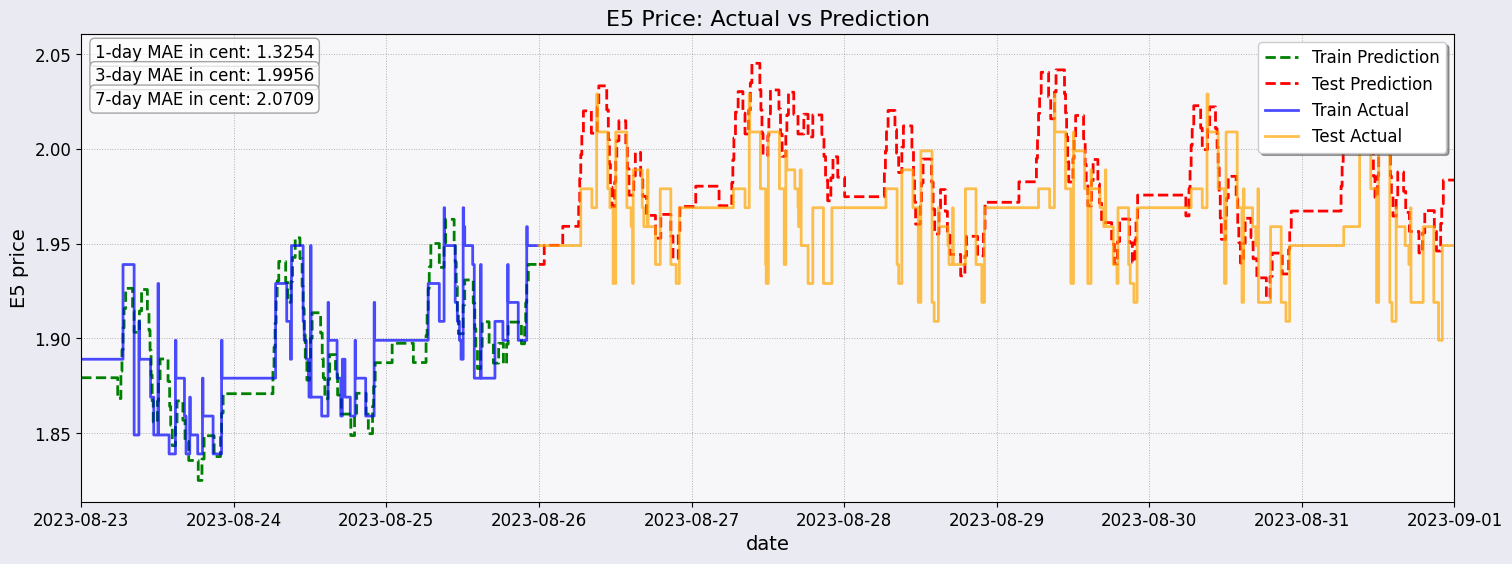

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/asvsr0nm.json


Successfully processed df01

Processing dataset: df02


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/8k06v6zg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23837', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/asvsr0nm.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/8k06v6zg.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/prophet_modell9b9ih3o/prophet_model-20250618174438.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:44:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 17:44:54 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 4.9657
3-Day MAE in cent: 5.8509
7-Day MAE in cent: 5.2535


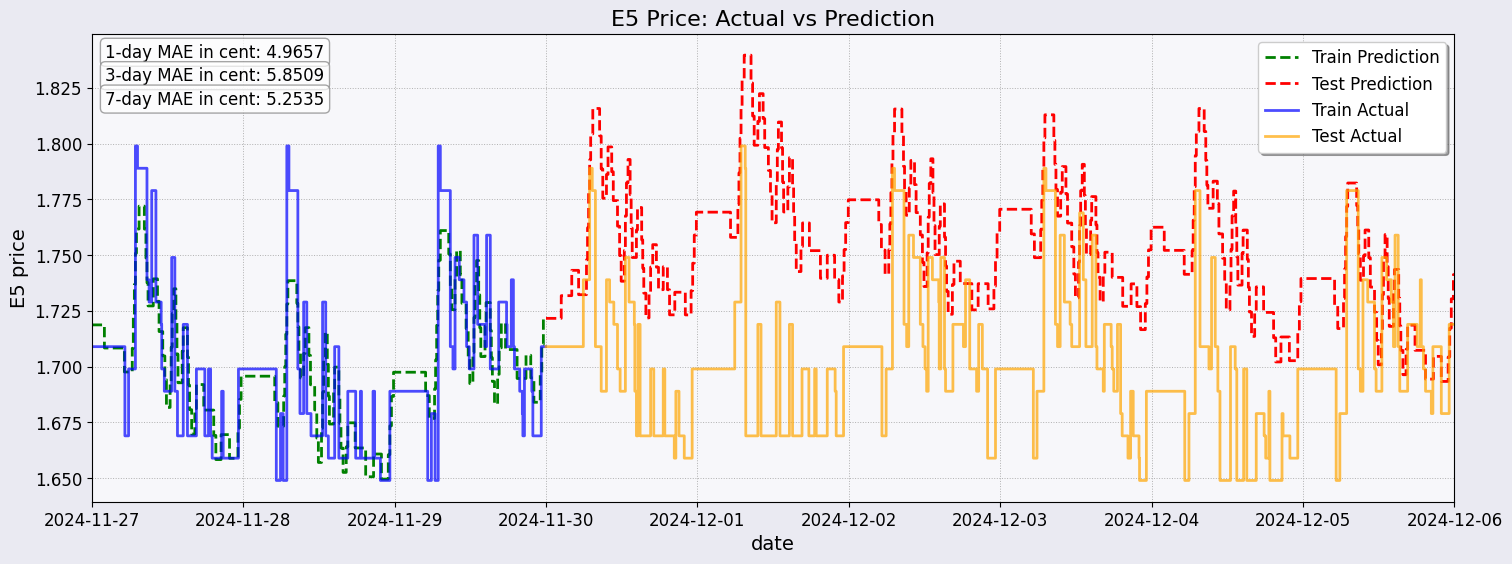

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/0q22xjcg.json


Successfully processed df02

Processing dataset: df03


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/irle3vzl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1281', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/0q22xjcg.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/irle3vzl.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/prophet_modelygmbljfp/prophet_model-20250618174456.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:44:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 17:45:05 WARNING mlflow.models.model: Model logged without a signature and inpu

1-Day MAE in cent: 1.4943
3-Day MAE in cent: 1.5991
7-Day MAE in cent: 2.1078


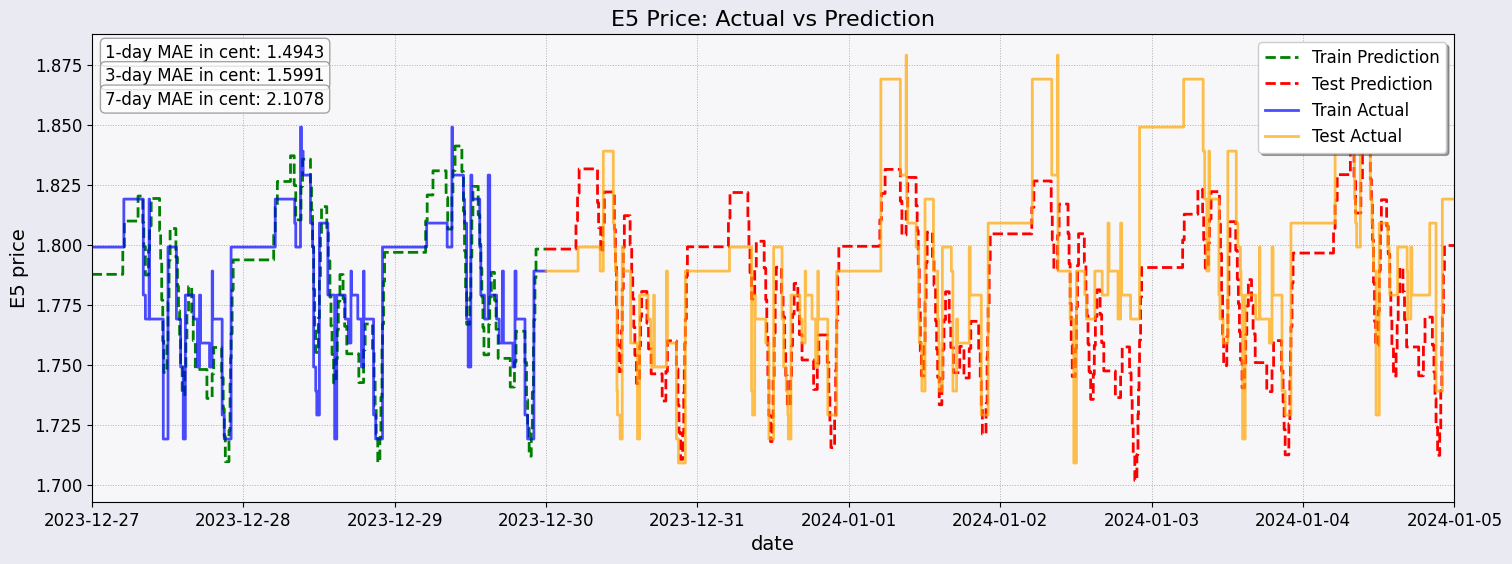

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/iykwyx33.json


Successfully processed df03

Processing dataset: df04


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/x5b4zxhd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72858', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/iykwyx33.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/x5b4zxhd.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/prophet_modelh7ik8z_9/prophet_model-20250618174506.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
2025/06/18 17:45:25 WARNING mlflow.models.model: Model logged without a signature and inp

1-Day MAE in cent: 1.2232
3-Day MAE in cent: 1.7199
7-Day MAE in cent: 1.5811


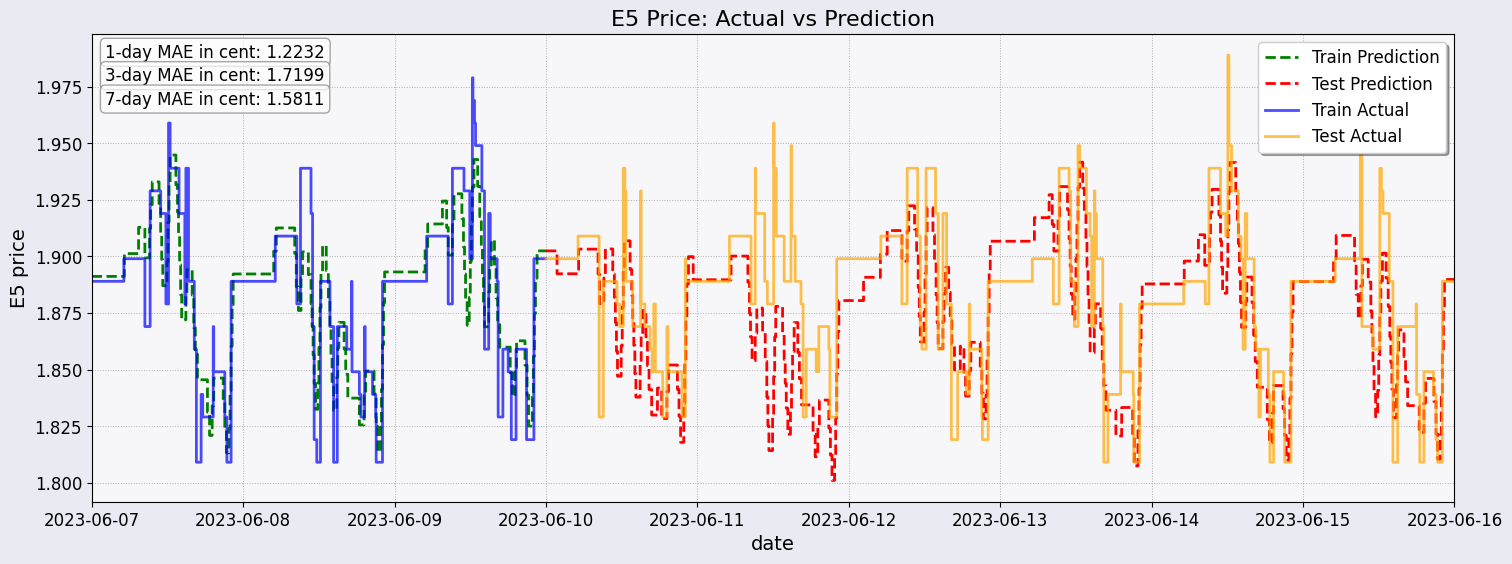

Successfully processed df04

Processing dataset: df05


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/t7_rmojc.json
DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/5fzuaaju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21718', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/t7_rmojc.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/5fzuaaju.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/prophet_modelmevbwkht/prophet_model-20250618174526.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:45:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1

1-Day MAE in cent: 2.9118
3-Day MAE in cent: 2.6405
7-Day MAE in cent: 3.0941


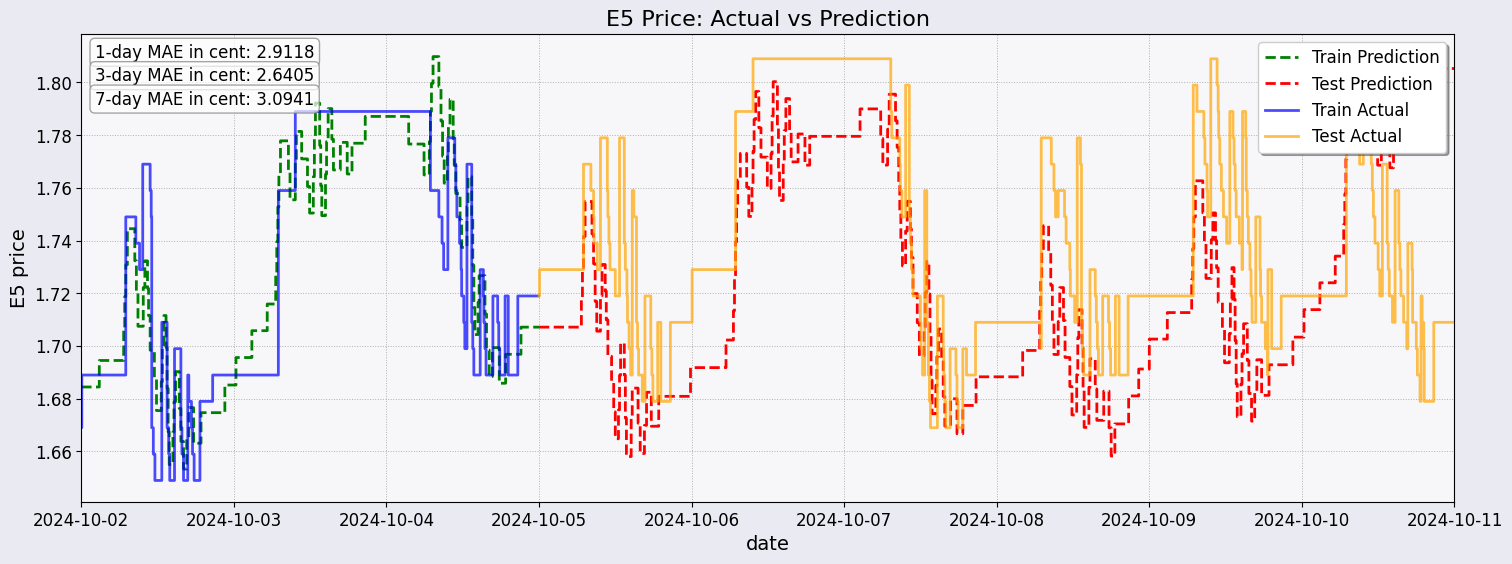

DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/5bsjqijb.json


Successfully processed df05

Processing dataset: df06


DEBUG:cmdstanpy:input tempfile: /var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/hsltrs04.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29423', 'data', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/5bsjqijb.json', 'init=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/hsltrs04.json', 'output', 'file=/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/tmppm2d875l/prophet_modelacxlg32f/prophet_model-20250618174548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:45:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


KeyboardInterrupt: 

In [ ]:
forecast_freq = 5 # minutes, discretization between individual values of the forecast
forecast_days = 7 # how many days should be forecasted
train_days = 30 # how many days will be used to train on
sampling_rate = 5 #in minutes, very important parameter

# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (df_train, df_test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    try:
        mlflow.end_run()

        with mlflow.start_run(run_name=f"fuel_model_Anton_{dataset_name}") as run:
            mlflow.set_tag("dataset", f'{dataset_name}')

            train_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = train_days)
            train_end = pd.to_datetime(df_train['date'].iloc[-1])
            # The forecast starts immediately after the training data ends
            forecast_start_date = train_end + pd.Timedelta(minutes=forecast_freq)
            # The forecast extends for 'forecast_days' from its start
            forecast_end_date = forecast_start_date + pd.Timedelta(days=forecast_days) - pd.Timedelta(minutes=forecast_freq)


            # block required to resample the data to the desired frequency
            #speeds up Prophet enormously
            df_prophet = df_train[(df_train['date'] >= train_start) & (df_train['date'] <= train_end) ]
            df_prophet.set_index('date', inplace = True)
            df_prophet.sort_index(inplace = True)
            df_prophet = df_prophet.asfreq(f'{sampling_rate}T')
            df_prophet = df_prophet.asfreq(pd.infer_freq(df_prophet.index)) # the infer_freq function will automatically detect the frequency of the time series data
            df_prophet = df_prophet.reset_index().rename(columns={'date': 'ds', 'e5': 'y'}) # Prophet requires certain column names for prediction
            df_prophet = df_prophet[['ds', 'y']]
    
    
            df_regressor = df_test[['date', 'e5']]
            df_regressor = df_regressor.rename(columns={'date': 'ds', 'e5': 'y'}) # Prophet requires certain column names for prediction
    
            df_regressor = pd.concat([df_prophet[['ds', 'y']],df_regressor]) # just to get also the visible predictions of the train set
    
            #Prophet itself
    
            m = Prophet(
                growth='linear',
    
                changepoint_prior_scale= 0.75,  # The higher the value, the more flexible the trend
                n_changepoints = 100, # Number of changepoints in the changepoint_range by default 80% of the data. In our case should be way higher and somehow connected to the train set length
                changepoint_range = 0.8, # The percentage of the history in which the changepoints are allowed to be placed. Default is 0.8. 
                #Since in our case the recent data is very important, try to extend to 0.9 or even 1. However for higher values fit sometimes goes nowhere
    
    
                seasonality_mode='additive', # in our case multiplicative should not be the better choice
                daily_seasonality=False,
                weekly_seasonality=False,
                yearly_seasonality=False
            )
            m.add_seasonality(name='daily', period=1, fourier_order=17, prior_scale = 30) # fourier 17 30
            m.add_seasonality(name='weekly', period= 7, fourier_order=20, prior_scale = 30) # fourier  20 40
    
            m.fit(df_prophet)
    
            forecast = m.predict(df_regressor)
            forecast = step_modification_to_forecast(forecast, threshold = 0.01) # makes the prediction less nervous:)
    
            mlflow.prophet.log_model(m)
    
            # Plot
    
            train_plot_start = pd.to_datetime(df_train['date'].iloc[-1]) - pd.Timedelta(days = 2)
            train_plot_end = pd.to_datetime(df_train['date'].iloc[-1]) + pd.Timedelta(days = 1)
    
            train_dates_plot = (train_plot_start.strftime('%Y-%m-%d'), train_plot_end.strftime('%Y-%m-%d'))
            test_dates_plot = (forecast_start_date.strftime('%Y-%m-%d'), forecast_end_date.strftime('%Y-%m-%d'))
    
            prophet_pred_plot = forecast[['ds', 'yhat']].copy()
            prophet_pred_plot = prophet_pred_plot.rename(columns={'ds': 'date', 'yhat': 'e5'})
            prophet_pred_plot['date'] = pd.to_datetime(prophet_pred_plot['date'])
    
            mae_1_day, mae_3_day, mae_7_day,r2_1_day, r2_3_day, r2_7_day = plot_forecast(
                 df_train,
                 df_test, 
                 None, 
                 prophet_pred_plot, 
                 prophet_pred_plot, 
                 train_dates_plot, 
                 test_dates_plot, 
                 train_dates_plot, 
                 test_dates_plot 
                 )
            mlflow.log_artifact("prediction.png")
            mlflow.log_metrics({
            "mae_1_day": mae_1_day,
            "mae_3_day": mae_3_day,
            "mae_7_day": mae_7_day,
            "r2_1_day": r2_1_day,
            "r2_3_day": r2_3_day,
            "r2_7_day": r2_7_day
            })


        print(f"Successfully processed {dataset_name}")

    except Exception as e:
            # Log the error and continue with next dataset
            error_message = f"Error in {dataset_name}: {str(e)}"
            error_log[dataset_name] = error_message
            print(error_message)

            # Make sure to end the MLflow run if it failed
            mlflow.end_run()
            continue


# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")


In [73]:
mlflow.end_run()

In [ ]:
#Check data:

%mlflow ui --backend-store-uri file:data/mlflow